In [1]:
import pytraj as pt
import nglview as nv
import numpy as np
from scipy.spatial.transform import Rotation

%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy

_ColormakerRegistry()

In [2]:
# load the PDB file
prot = pt.load('../proteins/6ct4.pdb')

# display the protein
view = nv.show_pytraj(prot)
#view.add_representation('licorice')
view

NGLWidget(max_frame=9)

In [3]:
view.close()

In [3]:
n_atoms = 0
residues = {}
for atom in prot.top.atoms:
    if atom.resid not in residues:
        # new residue
        residues[atom.resid] = {}
        atom_index = 0
        
    # add current atom to the residue dict
    residues[atom.resid][atom.name] = [prot.xyz[0][atom.index], atom.resname, atom.resid,
                                       atom.mass, n_atoms, atom_index]
    atom_index += 1
    n_atoms += 1

In [4]:
def angle(v1, v2):
    '''Returns the angle between v1 and v2 in radians'''
    return np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

def project_angle(v, p1, p2):
    '''Projects v onto the plane established by p1 and p2 and then returns the angle between v and the projection'''
    normal = np.cross(p1, p2)
    scalar_projection = np.linalg.norm(v) * (np.dot(v, normal) / (np.linalg.norm(v) * np.linalg.norm(normal)))
    vector_projection = scalar_projection * (normal / np.linalg.norm(normal))
    plane_projection = v - vector_projection
    return angle(plane_projection, p1)

def plot(residues, positions=None):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    for i, res in residues.items():
        if positions is None:
            #bb = np.stack([res['N'][0], res['CA'][0], res['C'][0]])
            bb = np.stack([res['N'][0], res['C'][0]])
        else:
            #bb = positions[[res['N'][-2], res['CA'][-2], res['C'][-2]]]
            bb = positions[[res['N'][-2], res['C'][-2]]]
        ax.plot(bb[:,0], bb[:,1], bb[:,2],
                linewidth=4,
                c=plt.get_cmap('jet')(i / len(residues)))

    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
distance = []
pitch = []
yaw = []
roll = []
folded = np.array([a[0] for res in residues.values() for a in res.values()])
for i in range(1, len(residues)):
    # -------- get external bond distance --------
    res0, res1 = residues[i-1], residues[i]
    distance.append(np.linalg.norm(folded[res0['C'][-2]] - folded[res1['N'][-2]]))
    
    # -------- get residue orientation --------
    res0_bb_vec = folded[res0['C'][-2]] - folded[res0['N'][-2]]
    res1_bb_vec = folded[res1['C'][-2]] - folded[res1['N'][-2]]
    
    res0_side_vec = folded[res0['CB'][-2]] - folded[res0['CA'][-2]]
    res1_side_vec = folded[res1['CB'][-2]] - folded[res1['CA'][-2]]
    
    res0_normal_vec = np.cross(res0_bb_vec, res0_side_vec)
    res1_normal_vec = np.cross(res1_bb_vec, res1_side_vec)
    
    # -------- get relative pitch and yaw angles --------
    pitch.append(project_angle(res1_bb_vec, res0_bb_vec, res0_side_vec))
    yaw.append(project_angle(res1_bb_vec, res0_bb_vec, res0_normal_vec))
    
    # -------- remove backbone pitch and yaw --------
    pitch_axis = res0_normal_vec / np.linalg.norm(res0_normal_vec)
    yaw_axis = res0_side_vec / np.linalg.norm(res0_side_vec)

    rot = Rotation.from_rotvec(pitch_axis * pitch[-1]) * Rotation.from_rotvec(yaw_axis * yaw[-1])
    rot_center = folded[res0['C'][-2]]
    ca_rot = rot.apply(folded[res1['CA'][-2]] - rot_center) + rot_center
    cb_rot = rot.apply(folded[res1['CB'][-2]] - rot_center) + rot_center

    # -------- get dihedral torsion angle (roll) --------
    roll.append(angle(res0_side_vec, cb_rot - ca_rot))

<IPython.core.display.Javascript object>


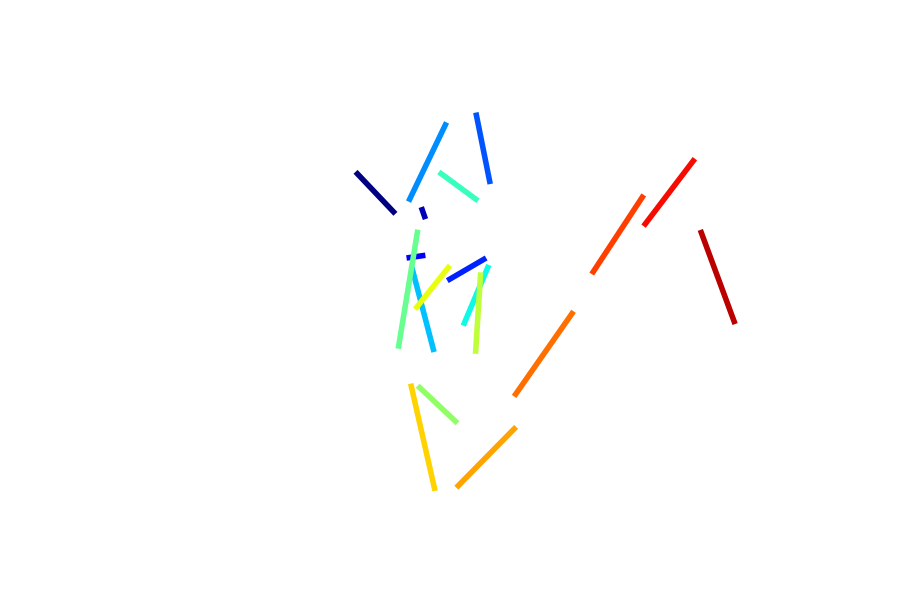

In [6]:
plot(residues, folded)

In [7]:
unfolded = np.array([a[0] for res in residues.values() for a in res.values()])
for i, res0 in residues.items():
    if i == len(residues) - 1:
        break
    res1 = residues[i+1]
    
    roll_axis = unfolded[res0['C'][-2]] - unfolded[res0['N'][-2]]
    yaw_axis = unfolded[res0['CB'][-2]] - unfolded[res0['CA'][-2]]
    pitch_axis = np.cross(roll_axis, yaw_axis)
    
    last_atom_idx = max(res[-2] for res in res0.values())
    
    # distance
    vec = unfolded[res1['N'][-2]] - unfolded[res0['C'][-2]]
    unfolded[last_atom_idx+1:] -= distance[i] * (vec / np.linalg.norm(vec))
    
    # pitch
    rot = Rotation.from_rotvec(pitch_axis / np.linalg.norm(pitch_axis) * pitch[i])
    rot_center = unfolded[res0['C'][-2]]
    unfolded[last_atom_idx+1:] = rot.apply(unfolded[last_atom_idx+1:] - rot_center) + rot_center
    
    # yaw
    rot = Rotation.from_rotvec(yaw_axis / np.linalg.norm(yaw_axis) * yaw[i])
    rot_center = unfolded[res0['C'][-2]]
    unfolded[last_atom_idx+1:] = rot.apply(unfolded[last_atom_idx+1:] - rot_center) + rot_center

    # roll
    rot = Rotation.from_rotvec(roll_axis / np.linalg.norm(roll_axis) * roll[i])
    rot_center = unfolded[res0['C'][-2]]
    unfolded[last_atom_idx+1:] = rot.apply(unfolded[last_atom_idx+1:] - rot_center) + rot_center

In [8]:
for i, res0 in residues.items():
    if i == len(residues) - 1:
        break
    res1 = residues[i+1]
    
    external_distance = np.linalg.norm(unfolded[res0['C'][-2]] - unfolded[res1['N'][-2]])
    
    res0_roll_axis = unfolded[res0['C'][-2]] - unfolded[res0['N'][-2]]
    res0_yaw_axis = unfolded[res0['CB'][-2]] - unfolded[res0['CA'][-2]]
    res0_pitch_axis = np.cross(res0_roll_axis, res0_yaw_axis)
    
    res1_roll_axis = unfolded[res1['C'][-2]] - unfolded[res1['N'][-2]]
    res1_yaw_axis = unfolded[res1['CB'][-2]] - unfolded[res1['CA'][-2]]
    res1_pitch_axis = np.cross(res1_roll_axis, res1_yaw_axis)
    
    print('dist\t', external_distance - distance[i])
    print('pitch\t', angle(res0_pitch_axis, res1_pitch_axis) - pitch[i])
    print('yaw\t', angle(res0_yaw_axis, res1_yaw_axis) - yaw[i])
    print('roll\t', angle(res0_roll_axis, res1_roll_axis) - roll[i])
    print()

dist	 -1.3096064294283212
pitch	 0.22738919285305131
yaw	 -0.32956028252401937
roll	 -1.152896282880793

dist	 -1.2992343899389371
pitch	 0.008258620201736955
yaw	 0.1292256338125814
roll	 -2.2682061247917567

dist	 -1.3194881583401952
pitch	 0.5368845430174052
yaw	 0.8456431668753562
roll	 -2.5600294901284197

dist	 -1.3260369527279372
pitch	 2.0237612187112894
yaw	 2.7014542597665994
roll	 -1.2963696912414637

dist	 -1.3223335433996968
pitch	 1.943241726329009
yaw	 2.514120516510566
roll	 -1.155696753694557

dist	 -1.329765016835678
pitch	 2.0543183725255294
yaw	 2.6062097555183725
roll	 -1.2165344812304433

dist	 -1.3303033488644591
pitch	 1.7995164086625879
yaw	 2.282810938395145
roll	 -1.0273868911917958

dist	 -1.3215059591239058
pitch	 1.8228672762378144
yaw	 2.363434357526404
roll	 -1.0703604275636067

dist	 -1.3171290749201447
pitch	 1.5454409104896223
yaw	 2.182286889332985
roll	 -0.960569685110316

dist	 -1.313249785836642
pitch	 2.0512434922585703
yaw	 2.8542723434895074
ro

<IPython.core.display.Javascript object>


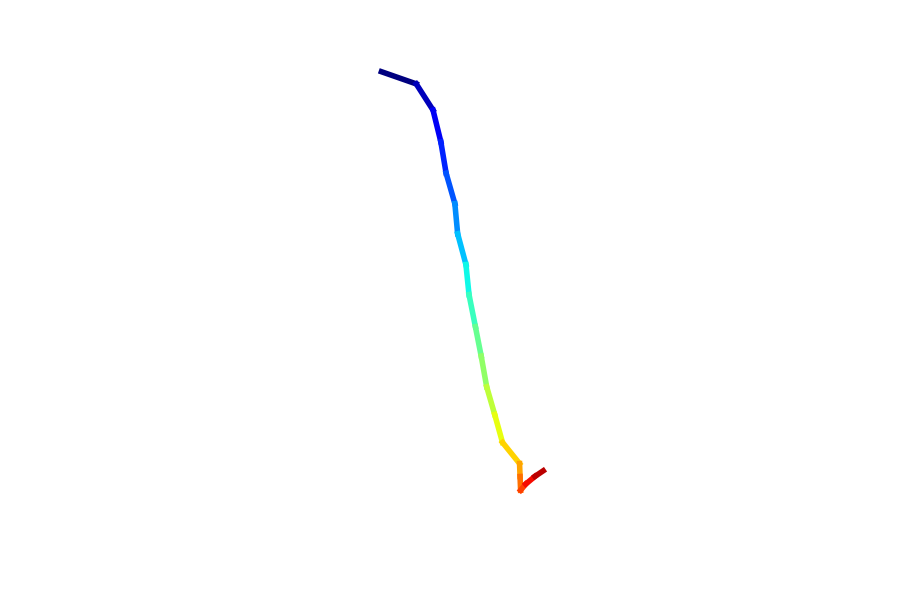

In [9]:
plot(residues, unfolded)